# Matched Field Processing with KRAKEN Acoustic Propagation Model

This notebook demonstrates how to use TritonOA and KRAKEN to perform matched field processing (MFP) using the Munk sound speed profile.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from tritonoa.at.models.kraken import runner
from tritonoa.signal.sp import covariance
from tritonoa.signal.mfp import MatchedFieldProcessor
from tritonoa.ssp import munk_ssp

ssp_data = munk_ssp(5000, 5)
z_data = ssp_data["z"]
c_data = ssp_data["c_p"]

environment = {
    # 1. General
    "title": "Munk",
    "model": "KRAKEN",
    # 2. Top medium (halfspace)
    # 3. Layered media
    "layerdata": [{"z": z_data, "c_p": c_data, "rho": 1.0}],
    # 4. Bottom medium
    "bot_opt": "A",
    "bot_c_p": 1600,
    "bot_rho": 1.8,
    "bot_a_p": 0.8,
    # 5. Speed constraints
    "clow": 0,
    "chigh": 1600,
    # 6. Receiver parameters
    "rec_z": np.arange(100, 900, 20).tolist(),
    "rec_r": 125.0,
    # "tilt": -1,
    # 7. Source parameters
    "src_z": 100.0,
}

freqs = [50, 100, 150]

covariance_matrix = []
for f in freqs:
    p_actual = runner.run_kraken(environment)
    K = covariance(p_actual)
    covariance_matrix.append(K)

processor = MatchedFieldProcessor(
    runner=runner.run_kraken,
    covariance_matrix=covariance_matrix,
    freq=freqs,
    parameters=environment,
)

rvec = np.linspace(1, 200, 40)
zvec = np.linspace(1, 5000, 20)
ambiguity_surface = np.zeros((len(zvec), len(rvec)))
for zz, z in enumerate(zvec):
    ambiguity_surface[zz, :] = processor({"src_z": z, "rec_r": rvec})

Next, the ambiguity surface is normalized and plotted with a decibel scale.

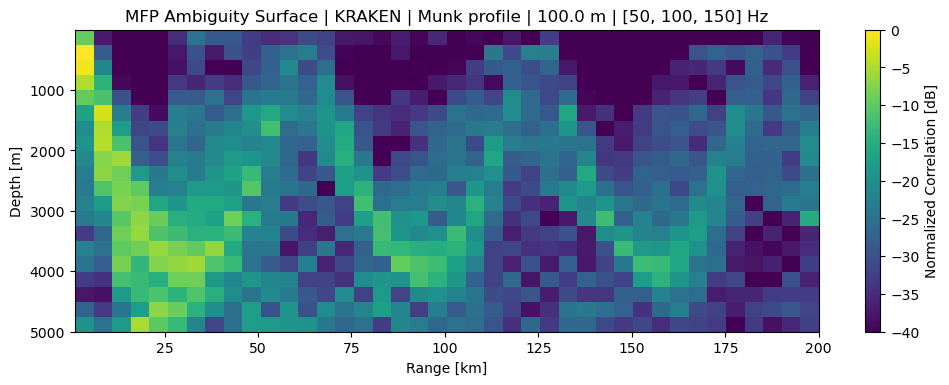

In [ ]:
amb_norm = np.abs(ambiguity_surface)
amb_norm /= amb_norm.max()
amb_norm = 10 * np.log10(amb_norm)

fig = plt.figure(figsize=(12, 4), facecolor="white", dpi=100)
plt.imshow(
    amb_norm,
    aspect="auto",
    origin="lower",
    extent=[rvec.min(), rvec.max(), zvec.min(), zvec.max()],
    vmin=-40,
    vmax=0
)
plt.gca().invert_yaxis()
plt.xlabel("Range [km]")
plt.ylabel("Depth [m]")
plt.title(f"MFP Ambiguity Surface | {environment['model']} | {environment['title']} profile | {environment['src_z']} m | {freqs} Hz")
cbar = plt.colorbar()
cbar.set_label("Normalized Correlation [dB]")
plt.show()